## Test fonction run exp

### 1. Imports

In [2]:
import torch
import stat_reliability_measure.config as config_
from importlib import reload
import matplotlib.pyplot as plt
import pprint
import scipy.stats as stats 
pp = pprint.PrettyPrinter(indent=4,depth=6,width=80,compact=True)

In [1]:
reload(t_u)

NameError: name 'reload' is not defined

In [4]:
import stat_reliability_measure.dev.torch_utils as t_u
import stat_reliability_measure.dev.torch_utils2 as t_u2
from stat_reliability_measure.dev.amls.amls_config import MLS_SMC_Config
import stat_reliability_measure.dev.utils as utils
import stat_reliability_measure.run_exp as run_exp
from stat_reliability_measure.config import ExpModelConfig
import stat_reliability_measure.dev.smc.smc_pyt as smc_pyt
import stat_reliability_measure.dev.smc.smc_pyt2 as smc_pyt2

import stat_reliability_measure.dev.smc.smc_config as smc_config
import stat_reliability_measure.dev.smc.smc_config2 as smc_config2

import stat_reliability_measure.dev.amls.amls_pyt as amls_pyt
import stat_reliability_measure.dev.form.form_pyt as form_pyt
import stat_reliability_measure.dev.amls.amls_config as amls_config 
import stat_reliability_measure.dev.mls.webb_config as webb_config
import stat_reliability_measure.dev.form.form_config as form_config
import stat_reliability_measure.dev.mls.amls_uniform as amls_webb
import stat_reliability_measure.dev.mc.mc_pyt as mc_pyt
import stat_reliability_measure.dev.mc.mc_config as mc_config
import stat_reliability_measure.dev.imp_sampling.is_pyt as is_pyt
import stat_reliability_measure.dev.imp_sampling.is_config as is_config
import stat_reliability_measure.dev.torch_arch as t_a
from stat_reliability_measure.dev.utils import range_vars,simple_vars
import pandas as pd
import numpy as np
import os 


### 2. Model & Data load

In [1]:
reload(config_)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
epsilon_range=[0.18]
input_index=18
#good seed : torch_seed = 111,np_seed = 0 

NameError: name 'reload' is not defined

Data loaded:  imagenet [random_seed = 0]
X.shape = torch.Size([15, 3, 224, 224]), y.shape = torch.Size([15])
Model accuracy: 0.75
Sample labels frequencies: 

("{'tench': 0.06666666666666667, 'goldfish': 0.06666666666666667, 'great white "
 "shark': 0.06666666666666667, 'tiger shark': 0.06666666666666667, 'hammerhead "
 "shark': 0.06666666666666667, 'electric ray': 0.06666666666666667, "
 "'stingray': 0.06666666666666667, 'cock': 0.06666666666666667, 'hen': "
 "0.06666666666666667, 'ostrich': 0.06666666666666667, 'brambling': "
 "0.06666666666666667, 'goldfinch': 0.06666666666666667, 'house finch': "
 "0.06666666666666667, 'junco': 0.06666666666666667, 'indigo bunting': "
 '0.06666666666666667}')
Plotting 15 ImageNet pictures


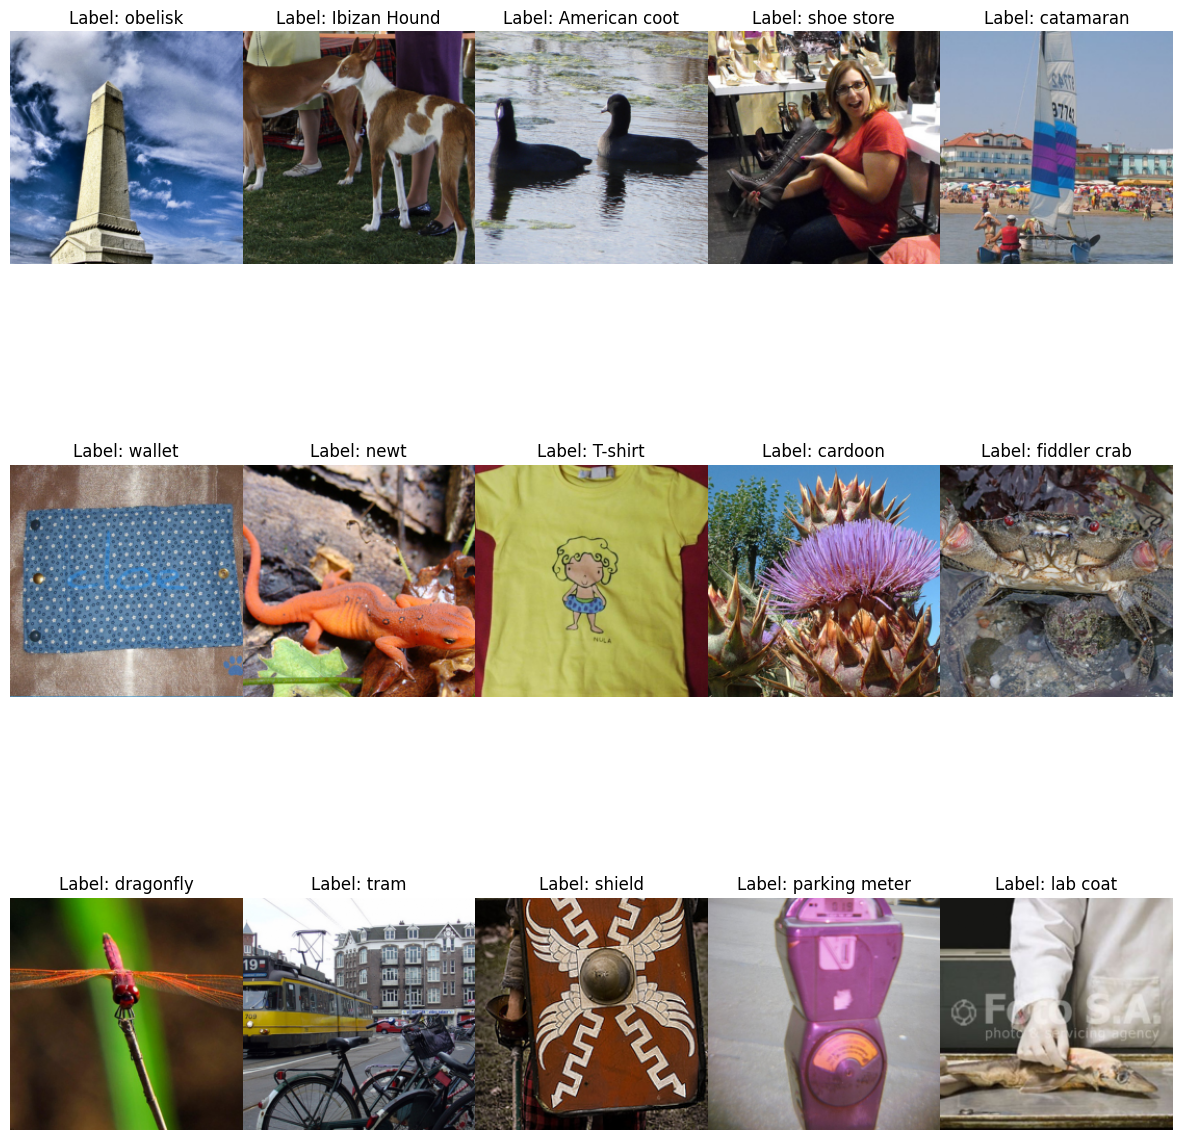

In [19]:
exp_config = config_.ExpModelConfig(dataset = 'imagenet', model_name = 'resnet18',data_dir = '../data/ImageNet', model_dir = '../models/ImageNet', device = device,
             torch_seed=42,np_seed=0,random_seed=0,shuffle=True, epsilon_range=epsilon_range,x_min=0.,x_max=1., input_index=input_index,real_uniform=False, load_batch_size=20,
             noise_dist='uniform')
imagenet_simple_labels = t_u.get_imagenet_simple_labels()
exp_config.update(input_idx=1)

print(f"Data loaded:  {exp_config.dataset} [random_seed = {exp_config.random_seed}]")
X_shape,y_shape = exp_config.X.shape,exp_config.y.shape

print(f"X.shape = {X_shape}, y.shape = {y_shape}")
y_numpy = exp_config.y.detach().cpu().numpy()
#print labels frequencies (real labels are given from imagenet_simple_labels)
labels, label_counts = np.unique(y_numpy,return_counts=True)
text_labels = [imagenet_simple_labels[i] for i in labels]
print(f"Model accuracy: {exp_config.sample_accuracy}")
print("Sample labels frequencies: \n" )
pp.pprint(f"{dict(zip(imagenet_simple_labels,label_counts/X_shape[0]))}")
x_0 = exp_config.X[input_index:input_index+1]
os.rmdir(exp_config.exp_log_path)
t_u.plot_imagenet_pictures(exp_config.X[:],exp_config.y[:],3,5)

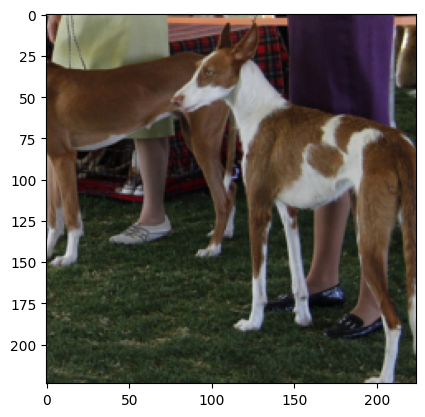

In [21]:
t_u.plot_tensor(exp_config.x_clean)

In [22]:
reload(is_pyt)

<module 'stat_reliability_measure.dev.imp_sampling.is_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/imp_sampling/is_pyt.py'>

In [23]:
N=128
k=18
X_normal = exp_config.gen(N)
dist_normal = torch.norm(X_normal,dim=-1)
G_X_normal = exp_config.G(X_normal)

index_topk = torch.topk(input=G_X_normal,k=k,largest=False, sorted=True).indices
print(f"h_score: {exp_config.h(X_normal)}")
print(f"h alt :{exp_config.h_alt(X_normal)}")
print(f"v_score: {exp_config.V(X_normal)}")
print(f"v score alt: {exp_config.V_alt(X_normal)}")
grad_v = exp_config.gradV(X_normal)[0][:2]

grad_v_alt = exp_config.gradV_alt(X_normal)[0][:2]

u = exp_config.normal_cdf_layer(X_normal.view(N,3,224,224))
del X_normal
logits_u = exp_config.model(u)
y_pred = torch.argmax( logits_u,-1)
delta_img = u-x_0
u_best = u[index_topk]
y_pred_best=y_pred[index_topk]
del u
#stats about delta_img
print(delta_img.min().item(),delta_img.max().item())
del delta_img
print(f" (gradv_autodiff-gradv_analytical)/gradv_autodiff:{((grad_v_alt-grad_v)/grad_v_alt).abs().max().item(),((grad_v_alt-grad_v)/grad_v_alt).abs().mean().item()}")
del grad_v,grad_v_alt


h_score: tensor([-1.0469, -0.5565, -1.0826, -0.8639,  0.7228,  0.5990, -2.4761,  1.7182,
         0.6700, -1.7207, -1.8010,  1.5681, -0.6867, -1.1023,  0.2915,  0.6564,
        -0.3388,  0.4036, -0.8290, -1.2626, -0.1191, -0.8840,  0.1097, -0.4507,
        -2.7741, -1.6761, -0.0188, -0.9539,  0.0589, -1.5059, -0.4976,  1.3069,
        -0.5882, -0.9935, -0.5937,  0.7948, -0.2352,  0.8855, -0.3235, -0.4739,
        -0.2952, -0.4661, -1.4185,  1.2511,  0.0332,  0.9889,  1.0863, -1.1799,
        -0.3229, -1.3138, -0.4913, -1.0742,  0.2406, -0.5652, -1.4318,  1.2012,
         0.6899,  0.1285, -0.5307, -0.0428, -2.6928,  0.0093, -0.0727, -0.1073,
        -1.3412, -0.8845, -1.0240, -1.1698,  1.6507,  0.2361,  1.3679,  0.0261,
         0.1030,  0.1459, -2.6721,  0.1333, -0.2159,  0.2417,  1.0803, -1.0497,
        -0.1659,  0.3173, -1.0733,  0.9865,  0.5791,  0.8111, -0.1890,  0.7382,
         0.1325,  0.8001, -0.5830,  0.1169, -1.3388,  1.4878,  0.5431,  0.5094,
         2.4891,  0.5793,  0.55

Distances between x_clean and x_attack: 

dist_linf_carlini: 0.0036045461893081665
dist_linf_fmna: 0.00028426945209503174
dist_linf_mpp: 0.003433123230934143
Norms of the corresponding latent variables: 

norm_x_attack: 0.5339953303337097
norm_x_mpp: 0.49348315596580505
norm_x_LinfFMNA: 0.7623028755187988
Reconstruction distances: 

dist_Linf_reconstr: 0.00028427131474018097
dist_L2_reconstr : 0.10948152840137482
dist_L2 relative to dimension: 0.0002821838834545777


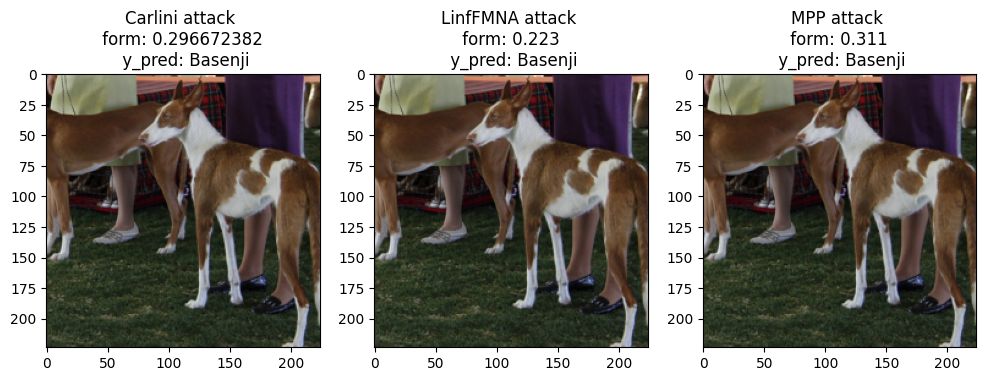

In [24]:
x_attack= is_pyt.gaussian_space_attack(x_clean=exp_config.x_clean,y_clean=exp_config.y_clean,model=exp_config.model, normal_cdf_layer=exp_config.normal_cdf_layer,attack='Carlini',
                                       random_init=False).reshape((1,exp_config.d))
dist_attack=torch.norm(x_attack).item()

form_attack=stats.norm.cdf(-dist_attack)
u_carlini=exp_config.normal_cdf_layer(x_attack)

y_pred_attack=torch.argmax(exp_config.model(u_carlini)).item()
y_carlini_text = t_u.imagenet_simple_labels[y_pred_attack]
dist_linf_carlini = (u_carlini-exp_config.x_clean).abs().max()
zero_latent=torch.zeros_like(x_attack).detach()
x_mpp,nb_calls_mpp = is_pyt.mpp_search(grad_f= exp_config.gradG_alt, zero_latent=zero_latent, max_iter=200)

form_mpp = stats.norm.cdf(-torch.norm(x_mpp).item())
u_mpp = exp_config.normal_cdf_layer(x_mpp)
y_mpp = torch.argmax(exp_config.model(u_mpp)).item()
y_mpp_text = t_u.imagenet_simple_labels[y_mpp]
dist_linf_mpp = (u_mpp-exp_config.x_clean).abs().max()
import foolbox as fb
fmodel=fb.models.PyTorchModel(model=exp_config.model, bounds = (0,1),)
linf_fmna = fb.attacks.LInfFMNAttack()
criterion = fb.criteria.Misclassification(exp_config.y_clean.unsqueeze(0))

u_LinfFMNA = linf_fmna(model = fmodel, inputs=exp_config.x_clean.unsqueeze(0), criterion=criterion,epsilons=[0.15,])[0][0]
dist_linf_fmna = (u_LinfFMNA-exp_config.x_clean).abs().max()
y_LinfFMNA = torch.argmax(exp_config.model(u_LinfFMNA)).item()
y_LinfFMNA_text = t_u.imagenet_simple_labels[y_LinfFMNA]
x_LinfFMNA=exp_config.normal_cdf_layer.inverse(u_LinfFMNA)
form_LinfFMNA = stats.norm.cdf(-torch.norm(x_LinfFMNA).item())
reconstr = exp_config.normal_cdf_layer(x_LinfFMNA)
dist_Linf_reconstr = (reconstr-exp_config.x_clean).abs().max()
dist_L2_reconstr = torch.norm(reconstr-exp_config.x_clean)

#print the different attacks distances 
print(f"Distances between x_clean and x_attack: \n")
print(f"dist_linf_carlini: {dist_linf_carlini.item()}")
print(f"dist_linf_fmna: {dist_linf_fmna.item()}")
print(f"dist_linf_mpp: {dist_linf_mpp.item()}")

print(f"Norms of the corresponding latent variables: \n")
print(f"norm_x_attack: {torch.norm(x_attack).item()}")
print(f"norm_x_mpp: {torch.norm(x_mpp).item()}")
print(f"norm_x_LinfFMNA: {torch.norm(x_LinfFMNA).item()}")

print(f"Reconstruction distances: \n")
print(f"dist_Linf_reconstr: {dist_Linf_reconstr.item()}")
print(f"dist_L2_reconstr : {dist_L2_reconstr.item()}")
print(f"dist_L2 relative to dimension: {dist_L2_reconstr.item()/np.sqrt(exp_config.d)}")

#plot the different attacks
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(u_carlini[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"Carlini attack \n form: {form_attack:.9f} \n y_pred: {y_carlini_text}")
plt.subplot(1,3,2)
plt.imshow(u_LinfFMNA[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"LinfFMNA attack \n form: {form_LinfFMNA:.3f} \n y_pred: {y_LinfFMNA_text}")
plt.subplot(1,3,3)
plt.imshow(u_mpp[0].detach().cpu().numpy().transpose((1,2,0)))
plt.title(f"MPP attack \n form: {form_mpp:.3f} \n y_pred: {y_mpp_text}")
plt.show()


Plotting 15 ImageNet pictures


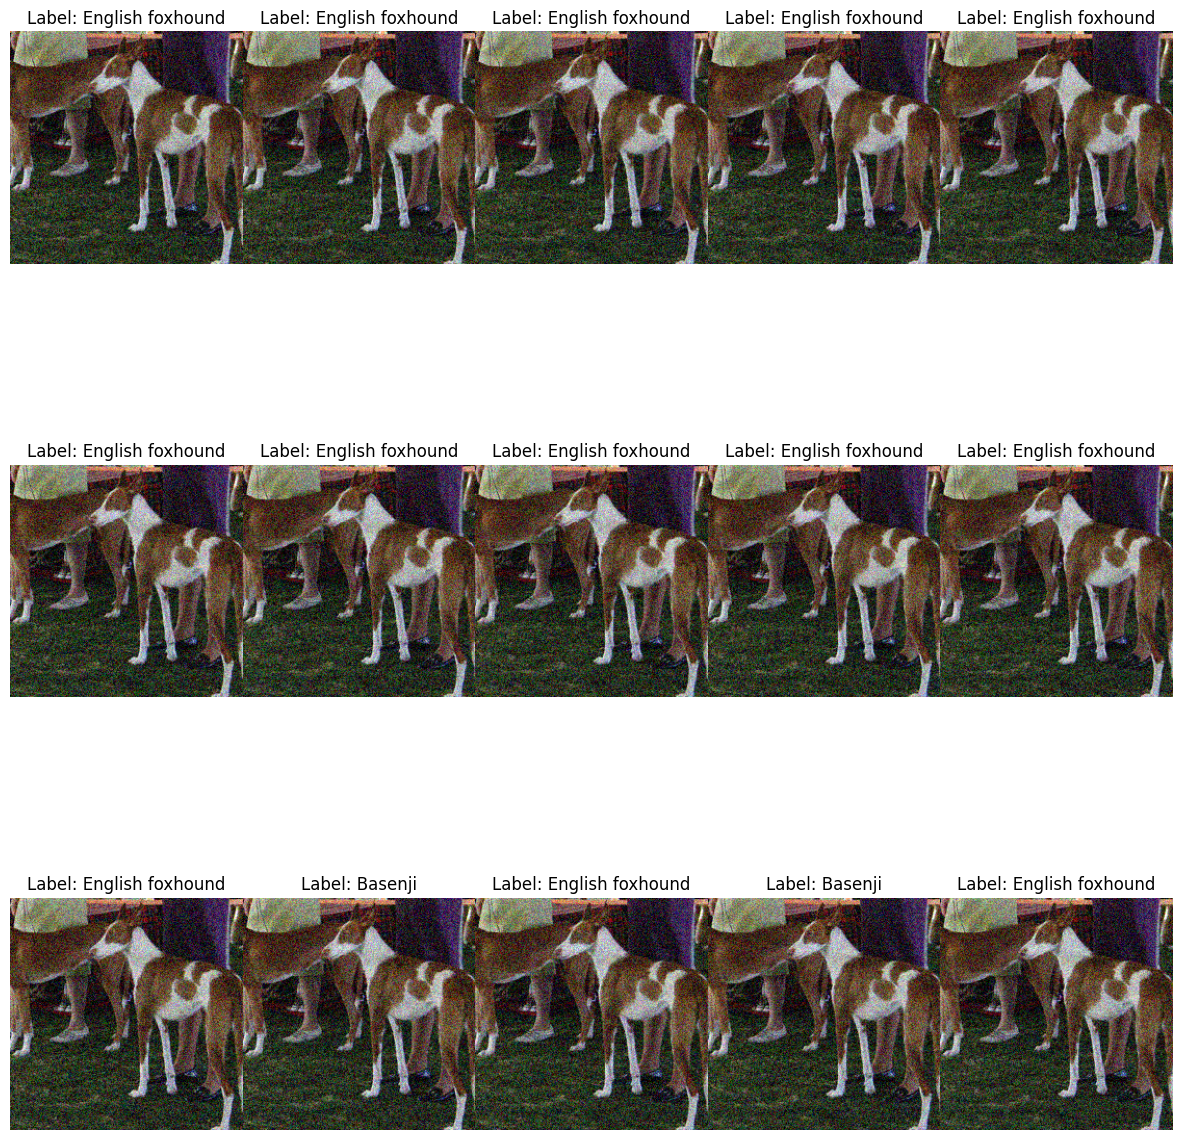

In [36]:
t_u.plot_imagenet_pictures(u_best[:],y_pred_best[:],3,5)

## 3. Experiments with MALA-SMC, ours implementation and Webb's implementation of AMLS algorithm

In [37]:

dataset='imagnet'
n_rep = 100 
method_ref='mala2'
method_ref_name='MALA_SMC'
N_ref = 128 
T_ref = 2
ess_ref = 0.5
alpha_ref = 0.25
n_rep_ref = 1
X = exp_config.X
y = exp_config.y
model = exp_config.model


In [38]:
exp_config.X.requires_grad = True

In [39]:
x_0 = exp_config.X[0]

In [42]:
del exp_config
torch.cuda.empty_cache()

In [105]:
p_ref, dict_out = run_exp.run_est( 
                                                repeat_exp=True, track_dt=False, 
                                             method='mala2', dataset_name=dataset,n_rep=20, verbose=0,
                                epsilon_range=epsilon_range, update_aggr_res=True ,track_accept=False,
                                N_range=[N_ref], T_range =[T_ref],ess_alpha = ess_ref,alpha=alpha_ref)

with parameters in {'N_range': [128], 'T_range': [2], 'ess_alpha_range': [0.5], 'alpha_range': [0.25], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: model, img_idx:0,eps:0.48, N: 128: T: 2: ess_alpha: 0.5: alpha: 0.25: L: 1


  0%|          | 0/20 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB. GPU 0 has a total capacty of 7.75 GiB of which 73.56 MiB is free. Including non-PyTorch memory, this process has 6.59 GiB memory in use. Of the allocated memory 6.07 GiB is allocated by PyTorch, and 384.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [20]:
agg_res_df

method_name  from_gaussian     N  rho  n_rep    T  epsilon  alpha  \
0     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
1     MALA_SMC           True    50  NaN    100    5     0.18   0.20   
2     MALA_SMC           True    50  NaN    100   10     0.18   0.20   
3     MALA_SMC           True   500  NaN    100   20     0.18   0.20   
4     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
5     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
6     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
7     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
8     MALA_SMC           True   500  NaN    100   20     0.18   0.20   
9     MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
10    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
11    MALA_SMC           True   500  NaN      1   20     0.18   0.20   
12    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
13    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
14    MALA_SMC           True   500  NaN    100   20     0.18   0.20   
15    MALA_SMC           True  4000  NaN    100  200     0.18   0.25   
16    MALA_SMC           True  4000  NaN    400  200     0.18   0.20   

    min_rate  mean_time  ...  num_classes   model_name  nb_inputs  \
0       0.15   0.402985  ...         10.0  mnist_model        1.0   
1       0.15   0.157510  ...         10.0  mnist_model        1.0   
2       0.15   0.210056  ...         10.0  mnist_model        1.0   
3       0.15   0.215504  ...         10.0  mnist_model        1.0   
4       0.15   0.416483  ...         10.0  mnist_model        1.0   
5       0.15   0.411512  ...         10.0  mnist_model        1.0   
6       0.15   0.692112  ...         10.0  mnist_model        1.0   
7       0.15   0.758556  ...         10.0  mnist_model        1.0   
8       0.15   0.223448  ...         10.0  mnist_model        1.0   
9       0.15   0.708665  ...         10.0  mnist_model        1.0   
10      0.15   0.360224  ...         10.0  mnist_model        1.0   
11      0.15   0.292626  ...         10.0  mnist_model        1.0   
12      0.15   0.324972  ...         10.0  mnist_model        1.0   
13      0.15   0.217970  ...         10.0  mnist_model        1.0   
14      0.15   0.461533  ...         10.0  mnist_model        1.0   
15      0.15   0.704430  ...         10.0  mnist_model        1.0   
16      0.15   0.541240  ...         10.0  mnist_model        1.0   

                                        raw_logs_path             loc_time  \
0   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_50_34   
1   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_54_07   
2   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_54_07   
3   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T11_55_25   
4   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_20_41   
5   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_46_05   
6   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_54_33   
7   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T17_57_19   
8   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T18_00_19   
9   /home/karimtito/repos/stat_reliability_measure...  2023_11_14T20_13_07   
10  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T20_18_48   
11  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_06_50   
12  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_07_14   
13  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_08_18   
14  /home/karimtito/repos/stat_reliability_measure...  2023_11_14T21_09_28   
15  /home/karimtito/repos/stat_reliability_measure...  2023_11_15T11_52_39   
16  /home/karimtito/repos/stat_reliability_measure...  2023_11_15T11_54_58   

                                         exp_log_path  exp

In [1]:
agg_res_df = pd.read_csv('../logs/exp_model_mnist/aggr_res.csv')
ref_exp = utils.get_sel_df(df=agg_res_df, triplets=[('method_name',method_ref,'='),('n_rep',n_rep_ref,'='),
                                                    ('epsilon',epsilon_range[0],'='),
        ('N',N_ref,'='),('T',T_ref,'='),('alpha',alpha_ref,'='), ])
p_ref,std_ref =ref_exp['mean_est'].values[0], ref_exp['std_est'].values[0]
p_ref,std_ref

NameError: name 'pd' is not defined

In [163]:
reload(amls_config)
reload(config_)
reload(webb_config)
reload(amls_webb)
reload(amls_pyt)
reload(smc_pyt)
reload(smc_pyt2)
reload(smc_config2)
reload(t_u2)
reload(run_exp)
reload(form_config)
reload(t_u)
reload(form_pyt)
reload(is_pyt)
reload(is_config)
reload(mc_config)
reload(mc_pyt)

<module 'stat_reliability_measure.dev.mc.mc_pyt' from '/home/karimtito/repos/stat_reliability_measure/dev/mc/mc_pyt.py'>

In [ ]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.8],
                        alpha=0.2, L_range=[1], only_duplicated=False,p_ref=p_ref,
                         N_range=[50],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )


exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [19]:
p_ref

1.3623007489660735e-08

model accuracy on sample batch:1.0
Running reliability experiments on architecture model trained on imagnet.
Testing uniform noise pertubation with epsilon in [0.25]
ModelExperimentConfig configuration: 
 config( adversarial_every=1, aggr_res_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagnet/aggr_res.csv, allow_multi_gpu=True, attack=PGD, clip_max=1_0, clip_min=0_0, commit=a1fee62a132a963a7ac7a1b635f90e056e7f6aca, data_dir=/home/karimtito/repos/stat_reliability_measure/data, dataset=imagnet, device=cuda:0, download=True, eps_max=0_25, eps_min=0_25, eps_num=1, epsilon=0_25, exp_log_path=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagnet/raw_logs/MLS_SMC/MLS_SMC_2023_11_19T19_32_24, exp_name=, export_to_onnx=False, force_train=False, from_gaussian=True, input_start=0, input_stop=1, lirpa_bounds=False, lirpa_cert=False, load_batch_size=128, loc_time=2023_11_19T19_32_24, log_dir=/home/karimtito/repos/stat_reliability_measure/logs/exp_model_imagne

  0%|          | 0/20 [00:00<?, ?it/s]

Iter =  1  tau_j =  -8.2860107421875 h_mean -8.181532859802246  Calls =  128
Iter =  2  tau_j =  -7.261707305908203 h_mean -7.0715227127075195  Calls =  768
Iter =  3  tau_j =  -6.6696014404296875 h_mean -6.414974212646484  Calls =  1408
Iter =  4  tau_j =  -6.104504585266113 h_mean -5.914881706237793  Calls =  2048
Iter =  5  tau_j =  -5.499839782714844 h_mean -5.317718505859375  Calls =  2688
Iter =  6  tau_j =  -5.01369571685791 h_mean -4.8062238693237305  Calls =  3328
Iter =  7  tau_j =  -4.56778621673584 h_mean -4.344011306762695  Calls =  3968
Iter =  8  tau_j =  -4.070228576660156 h_mean -3.94492506980896  Calls =  4608
Iter =  9  tau_j =  -3.7033703327178955 h_mean -3.513234853744507  Calls =  5248
Iter =  10  tau_j =  -3.350754499435425 h_mean -3.2122178077697754  Calls =  5888
Iter =  11  tau_j =  -3.022700309753418 h_mean -2.9137139320373535  Calls =  6528
Iter =  12  tau_j =  -2.803898572921753 h_mean -2.6241559982299805  Calls =  7168
Iter =  13  tau_j =  -2.1371569633483

  5%|▌         | 1/20 [00:16<05:11, 16.37s/it]

Iter =  36  tau_j =  1.3590235710144043 h_mean 1.0021098852157593  Calls =  22528
Iter =  1  tau_j =  -8.086719512939453 h_mean -8.132307052612305  Calls =  128
Iter =  2  tau_j =  -7.241196632385254 h_mean -7.096962928771973  Calls =  768
Iter =  3  tau_j =  -6.518465042114258 h_mean -6.405211448669434  Calls =  1408
Iter =  4  tau_j =  -5.983978271484375 h_mean -5.763729095458984  Calls =  2048
Iter =  5  tau_j =  -5.450504302978516 h_mean -5.248679161071777  Calls =  2688
Iter =  6  tau_j =  -4.9108381271362305 h_mean -4.806684494018555  Calls =  3328
Iter =  7  tau_j =  -4.5588274002075195 h_mean -4.398374557495117  Calls =  3968
Iter =  8  tau_j =  -4.104525566101074 h_mean -3.9915695190429688  Calls =  4608
Iter =  9  tau_j =  -3.7545814514160156 h_mean -3.6676039695739746  Calls =  5248
Iter =  10  tau_j =  -3.391580104827881 h_mean -3.37815523147583  Calls =  5888
Iter =  11  tau_j =  -3.2751102447509766 h_mean -3.1832592487335205  Calls =  6528
Iter =  12  tau_j =  -3.11904788

 10%|█         | 2/20 [00:31<04:40, 15.60s/it]

Iter =  33  tau_j =  0.05897879600524902 h_mean 0.030907832086086273  Calls =  20608
Iter =  1  tau_j =  -7.949572563171387 h_mean -7.858396053314209  Calls =  128
Iter =  2  tau_j =  -7.024176597595215 h_mean -6.801045894622803  Calls =  768
Iter =  3  tau_j =  -6.289536476135254 h_mean -6.187804222106934  Calls =  1408
Iter =  4  tau_j =  -5.816409587860107 h_mean -5.697007179260254  Calls =  2048
Iter =  5  tau_j =  -5.395031452178955 h_mean -5.295056343078613  Calls =  2688
Iter =  6  tau_j =  -5.041757106781006 h_mean -4.856757164001465  Calls =  3328
Iter =  7  tau_j =  -4.628026962280273 h_mean -4.4715375900268555  Calls =  3968
Iter =  8  tau_j =  -4.281902313232422 h_mean -4.064174652099609  Calls =  4608
Iter =  9  tau_j =  -3.9135758876800537 h_mean -3.727019786834717  Calls =  5248
Iter =  10  tau_j =  -3.444096565246582 h_mean -3.353163242340088  Calls =  5888
Iter =  11  tau_j =  -3.061633348464966 h_mean -3.0092039108276367  Calls =  6528
Iter =  12  tau_j =  -2.86166977

 15%|█▌        | 3/20 [00:43<03:55, 13.85s/it]

Iter =  26  tau_j =  0.6472716331481934 h_mean 0.3308722674846649  Calls =  16128
Iter =  1  tau_j =  -8.155120849609375 h_mean -8.16191291809082  Calls =  128
Iter =  2  tau_j =  -7.316422939300537 h_mean -7.152913570404053  Calls =  768
Iter =  3  tau_j =  -6.655561447143555 h_mean -6.407573223114014  Calls =  1408
Iter =  4  tau_j =  -6.018993377685547 h_mean -5.815211296081543  Calls =  2048
Iter =  5  tau_j =  -5.4910736083984375 h_mean -5.282130241394043  Calls =  2688
Iter =  6  tau_j =  -4.981189727783203 h_mean -4.813075065612793  Calls =  3328
Iter =  7  tau_j =  -4.542206764221191 h_mean -4.351171493530273  Calls =  3968
Iter =  8  tau_j =  -4.117186546325684 h_mean -3.9463415145874023  Calls =  4608
Iter =  9  tau_j =  -3.6394243240356445 h_mean -3.53763484954834  Calls =  5248
Iter =  10  tau_j =  -3.3267149925231934 h_mean -3.2199199199676514  Calls =  5888
Iter =  11  tau_j =  -3.021878242492676 h_mean -2.9298007488250732  Calls =  6528
Iter =  12  tau_j =  -2.8029010295

 20%|██        | 4/20 [01:29<07:04, 26.51s/it]

Iter =  99  tau_j =  0.10067641735076904 h_mean 0.07665226608514786  Calls =  62848
Iter =  1  tau_j =  -8.154773712158203 h_mean -8.027536392211914  Calls =  128
Iter =  2  tau_j =  -7.139603137969971 h_mean -6.904427528381348  Calls =  768
Iter =  3  tau_j =  -6.452362537384033 h_mean -6.253903388977051  Calls =  1408
Iter =  4  tau_j =  -5.916291236877441 h_mean -5.720541477203369  Calls =  2048
Iter =  5  tau_j =  -5.314498424530029 h_mean -5.152192115783691  Calls =  2688
Iter =  6  tau_j =  -4.7804059982299805 h_mean -4.627847671508789  Calls =  3328
Iter =  7  tau_j =  -4.417610168457031 h_mean -4.227590084075928  Calls =  3968
Iter =  8  tau_j =  -3.9876582622528076 h_mean -3.8785173892974854  Calls =  4608
Iter =  9  tau_j =  -3.7372708320617676 h_mean -3.539900779724121  Calls =  5248
Iter =  10  tau_j =  -3.4031524658203125 h_mean -3.220184326171875  Calls =  5888
Iter =  11  tau_j =  -2.8032705783843994 h_mean -2.820460796356201  Calls =  6528
Iter =  12  tau_j =  -2.511117

 25%|██▌       | 5/20 [01:54<06:33, 26.25s/it]

Iter =  56  tau_j =  0.058364152908325195 h_mean -0.0069409701973199844  Calls =  35328
Iter =  1  tau_j =  -8.396245956420898 h_mean -8.18869686126709  Calls =  128
Iter =  2  tau_j =  -7.463400840759277 h_mean -7.128455638885498  Calls =  768
Iter =  3  tau_j =  -6.744964122772217 h_mean -6.412599563598633  Calls =  1408
Iter =  4  tau_j =  -6.108325004577637 h_mean -5.87951135635376  Calls =  2048
Iter =  5  tau_j =  -5.571261405944824 h_mean -5.393324851989746  Calls =  2688
Iter =  6  tau_j =  -5.075198173522949 h_mean -4.956319808959961  Calls =  3328
Iter =  7  tau_j =  -4.645639419555664 h_mean -4.509565353393555  Calls =  3968
Iter =  8  tau_j =  -4.291546821594238 h_mean -4.173154354095459  Calls =  4608
Iter =  9  tau_j =  -3.9131276607513428 h_mean -3.7865195274353027  Calls =  5248
Iter =  10  tau_j =  -3.574721336364746 h_mean -3.4554200172424316  Calls =  5888
Iter =  11  tau_j =  -3.4134328365325928 h_mean -3.1985814571380615  Calls =  6528
Iter =  12  tau_j =  -3.06545

 30%|███       | 6/20 [02:08<05:05, 21.79s/it]

Iter =  29  tau_j =  0.033838748931884766 h_mean 0.004892653785645962  Calls =  18048
Iter =  1  tau_j =  -8.146622657775879 h_mean -7.989779472351074  Calls =  128
Iter =  2  tau_j =  -7.146529674530029 h_mean -6.938848495483398  Calls =  768
Iter =  3  tau_j =  -6.480472564697266 h_mean -6.253209590911865  Calls =  1408
Iter =  4  tau_j =  -5.916909217834473 h_mean -5.734356880187988  Calls =  2048
Iter =  5  tau_j =  -5.333598613739014 h_mean -5.223907470703125  Calls =  2688
Iter =  6  tau_j =  -4.835834503173828 h_mean -4.735162734985352  Calls =  3328
Iter =  7  tau_j =  -4.538932800292969 h_mean -4.341683387756348  Calls =  3968
Iter =  8  tau_j =  -4.090226173400879 h_mean -4.029987335205078  Calls =  4608
Iter =  9  tau_j =  -3.7877564430236816 h_mean -3.7693395614624023  Calls =  5248
Iter =  10  tau_j =  -3.6426970958709717 h_mean -3.5505497455596924  Calls =  5888
Iter =  11  tau_j =  -3.4564809799194336 h_mean -3.351567268371582  Calls =  6528
Iter =  12  tau_j =  -3.17979

 35%|███▌      | 7/20 [02:30<04:46, 22.01s/it]

Iter =  49  tau_j =  0.3495767116546631 h_mean 0.184775710105896  Calls =  30848
Iter =  1  tau_j =  -8.033215522766113 h_mean -8.025604248046875  Calls =  128
Iter =  2  tau_j =  -7.2415313720703125 h_mean -6.960619926452637  Calls =  768
Iter =  3  tau_j =  -6.473180770874023 h_mean -6.320079326629639  Calls =  1408
Iter =  4  tau_j =  -5.972257614135742 h_mean -5.763887882232666  Calls =  2048
Iter =  5  tau_j =  -5.380463600158691 h_mean -5.276120185852051  Calls =  2688
Iter =  6  tau_j =  -5.1001739501953125 h_mean -4.90543794631958  Calls =  3328
Iter =  7  tau_j =  -4.824052810668945 h_mean -4.601478576660156  Calls =  3968
Iter =  8  tau_j =  -4.378113269805908 h_mean -4.219758033752441  Calls =  4608
Iter =  9  tau_j =  -3.9179112911224365 h_mean -3.7951431274414062  Calls =  5248
Iter =  10  tau_j =  -3.490813970565796 h_mean -3.406081438064575  Calls =  5888
Iter =  11  tau_j =  -3.1417906284332275 h_mean -3.0638160705566406  Calls =  6528
Iter =  12  tau_j =  -2.7352583408

 40%|████      | 8/20 [02:48<04:10, 20.84s/it]

Iter =  40  tau_j =  0.5445950031280518 h_mean 0.4012557864189148  Calls =  25088
Iter =  1  tau_j =  -8.149386405944824 h_mean -7.943192958831787  Calls =  128
Iter =  2  tau_j =  -7.046060562133789 h_mean -6.926579475402832  Calls =  768
Iter =  3  tau_j =  -6.480722427368164 h_mean -6.2787885665893555  Calls =  1408
Iter =  4  tau_j =  -5.89583683013916 h_mean -5.692538738250732  Calls =  2048
Iter =  5  tau_j =  -5.365983009338379 h_mean -5.208740234375  Calls =  2688
Iter =  6  tau_j =  -4.935189247131348 h_mean -4.750274658203125  Calls =  3328
Iter =  7  tau_j =  -4.537121295928955 h_mean -4.405878067016602  Calls =  3968
Iter =  8  tau_j =  -4.294013023376465 h_mean -4.1362104415893555  Calls =  4608
Iter =  9  tau_j =  -4.002626419067383 h_mean -3.8559186458587646  Calls =  5248
Iter =  10  tau_j =  -3.5940463542938232 h_mean -3.571536064147949  Calls =  5888
Iter =  11  tau_j =  -3.4566915035247803 h_mean -3.317065477371216  Calls =  6528
Iter =  12  tau_j =  -3.2226810455322

 45%|████▌     | 9/20 [03:07<03:40, 20.02s/it]

Iter =  40  tau_j =  0.046144723892211914 h_mean -0.02048337459564209  Calls =  25088
Iter =  1  tau_j =  -8.054943084716797 h_mean -7.951200485229492  Calls =  128
Iter =  2  tau_j =  -7.1002516746521 h_mean -6.927494525909424  Calls =  768
Iter =  3  tau_j =  -6.35957145690918 h_mean -6.231692314147949  Calls =  1408
Iter =  4  tau_j =  -5.898134231567383 h_mean -5.716104507446289  Calls =  2048
Iter =  5  tau_j =  -5.51261568069458 h_mean -5.294940948486328  Calls =  2688
Iter =  6  tau_j =  -4.96563196182251 h_mean -4.883050918579102  Calls =  3328
Iter =  7  tau_j =  -4.626145839691162 h_mean -4.394153594970703  Calls =  3968
Iter =  8  tau_j =  -4.227893829345703 h_mean -4.049890041351318  Calls =  4608
Iter =  9  tau_j =  -3.6985130310058594 h_mean -3.650723695755005  Calls =  5248
Iter =  10  tau_j =  -3.4412636756896973 h_mean -3.267184257507324  Calls =  5888
Iter =  11  tau_j =  -3.1232805252075195 h_mean -2.9512016773223877  Calls =  6528
Iter =  12  tau_j =  -2.67451047897

 50%|█████     | 10/20 [03:22<03:07, 18.76s/it]

Iter =  35  tau_j =  0.023710250854492188 h_mean -0.02283567190170288  Calls =  21888
Iter =  1  tau_j =  -8.029306411743164 h_mean -7.948930740356445  Calls =  128
Iter =  2  tau_j =  -7.162357330322266 h_mean -6.953402519226074  Calls =  768
Iter =  3  tau_j =  -6.5018415451049805 h_mean -6.339189529418945  Calls =  1408
Iter =  4  tau_j =  -5.908787727355957 h_mean -5.767478942871094  Calls =  2048
Iter =  5  tau_j =  -5.548681259155273 h_mean -5.328513145446777  Calls =  2688
Iter =  6  tau_j =  -5.137429237365723 h_mean -4.937314510345459  Calls =  3328
Iter =  7  tau_j =  -4.715000152587891 h_mean -4.608497142791748  Calls =  3968
Iter =  8  tau_j =  -4.280559539794922 h_mean -4.172947883605957  Calls =  4608
Iter =  9  tau_j =  -3.945018768310547 h_mean -3.860264301300049  Calls =  5248
Iter =  10  tau_j =  -3.664245128631592 h_mean -3.5473361015319824  Calls =  5888
Iter =  11  tau_j =  -3.321549415588379 h_mean -3.279651165008545  Calls =  6528
Iter =  12  tau_j =  -3.11460471

 55%|█████▌    | 11/20 [03:36<02:34, 17.19s/it]

Iter =  30  tau_j =  0.12468457221984863 h_mean -0.05948467552661896  Calls =  18688
Iter =  1  tau_j =  -8.295219421386719 h_mean -8.183324813842773  Calls =  128
Iter =  2  tau_j =  -7.2251996994018555 h_mean -7.040874481201172  Calls =  768
Iter =  3  tau_j =  -6.43333101272583 h_mean -6.233278751373291  Calls =  1408
Iter =  4  tau_j =  -5.829063892364502 h_mean -5.630547523498535  Calls =  2048
Iter =  5  tau_j =  -5.359788417816162 h_mean -5.151766777038574  Calls =  2688
Iter =  6  tau_j =  -4.955278396606445 h_mean -4.736039161682129  Calls =  3328
Iter =  7  tau_j =  -4.518749237060547 h_mean -4.374598979949951  Calls =  3968
Iter =  8  tau_j =  -4.224384784698486 h_mean -4.052595138549805  Calls =  4608
Iter =  9  tau_j =  -3.8840057849884033 h_mean -3.7179579734802246  Calls =  5248
Iter =  10  tau_j =  -3.61773681640625 h_mean -3.357959032058716  Calls =  5888
Iter =  11  tau_j =  -3.1389403343200684 h_mean -2.999211311340332  Calls =  6528
Iter =  12  tau_j =  -2.690312862

 60%|██████    | 12/20 [03:53<02:15, 16.97s/it]

Iter =  36  tau_j =  0.07806128263473511 h_mean -0.04785577207803726  Calls =  22528
Iter =  1  tau_j =  -8.12348747253418 h_mean -8.125020027160645  Calls =  128
Iter =  2  tau_j =  -7.363654613494873 h_mean -7.073365688323975  Calls =  768
Iter =  3  tau_j =  -6.599428176879883 h_mean -6.378961563110352  Calls =  1408
Iter =  4  tau_j =  -5.90064811706543 h_mean -5.799808502197266  Calls =  2048
Iter =  5  tau_j =  -5.416815757751465 h_mean -5.264345169067383  Calls =  2688
Iter =  6  tau_j =  -5.00301456451416 h_mean -4.776766300201416  Calls =  3328
Iter =  7  tau_j =  -4.578557968139648 h_mean -4.355460166931152  Calls =  3968
Iter =  8  tau_j =  -4.067789554595947 h_mean -3.9398748874664307  Calls =  4608
Iter =  9  tau_j =  -3.759169816970825 h_mean -3.5681631565093994  Calls =  5248
Iter =  10  tau_j =  -3.2996928691864014 h_mean -3.238253116607666  Calls =  5888
Iter =  11  tau_j =  -3.110929012298584 h_mean -2.9221701622009277  Calls =  6528
Iter =  12  tau_j =  -2.8843107223

 65%|██████▌   | 13/20 [04:04<01:47, 15.39s/it]

Iter =  26  tau_j =  0.48682624101638794 h_mean 0.2542729675769806  Calls =  16128
Iter =  1  tau_j =  -8.072154998779297 h_mean -7.88034200668335  Calls =  128
Iter =  2  tau_j =  -7.068148612976074 h_mean -6.8390960693359375  Calls =  768
Iter =  3  tau_j =  -6.337757110595703 h_mean -6.119611740112305  Calls =  1408
Iter =  4  tau_j =  -5.826301097869873 h_mean -5.607372760772705  Calls =  2048
Iter =  5  tau_j =  -5.455164909362793 h_mean -5.199037075042725  Calls =  2688
Iter =  6  tau_j =  -4.902693748474121 h_mean -4.789356231689453  Calls =  3328
Iter =  7  tau_j =  -4.495165824890137 h_mean -4.370128154754639  Calls =  3968
Iter =  8  tau_j =  -4.06239128112793 h_mean -4.023828029632568  Calls =  4608
Iter =  9  tau_j =  -3.773487091064453 h_mean -3.688735008239746  Calls =  5248
Iter =  10  tau_j =  -3.4760520458221436 h_mean -3.398703098297119  Calls =  5888
Iter =  11  tau_j =  -3.300572156906128 h_mean -3.1841416358947754  Calls =  6528
Iter =  12  tau_j =  -3.218361139297

 70%|███████   | 14/20 [04:25<01:41, 16.96s/it]

Iter =  45  tau_j =  0.0625794529914856 h_mean 0.007213043048977852  Calls =  28288
Iter =  1  tau_j =  -8.225292205810547 h_mean -8.175409317016602  Calls =  128
Iter =  2  tau_j =  -7.458616256713867 h_mean -7.166146278381348  Calls =  768
Iter =  3  tau_j =  -6.603332996368408 h_mean -6.44202184677124  Calls =  1408
Iter =  4  tau_j =  -5.94622278213501 h_mean -5.834553241729736  Calls =  2048
Iter =  5  tau_j =  -5.515016078948975 h_mean -5.318635940551758  Calls =  2688
Iter =  6  tau_j =  -5.136282920837402 h_mean -4.903397560119629  Calls =  3328
Iter =  7  tau_j =  -4.659356117248535 h_mean -4.522010326385498  Calls =  3968
Iter =  8  tau_j =  -4.206599235534668 h_mean -4.10000467300415  Calls =  4608
Iter =  9  tau_j =  -3.9199094772338867 h_mean -3.714019298553467  Calls =  5248
Iter =  10  tau_j =  -3.594301223754883 h_mean -3.366593837738037  Calls =  5888
Iter =  11  tau_j =  -2.9930267333984375 h_mean -3.0181515216827393  Calls =  6528
Iter =  12  tau_j =  -2.969260692596

 75%|███████▌  | 15/20 [04:35<01:14, 14.99s/it]

Iter =  23  tau_j =  0.03542923927307129 h_mean -0.15542209148406982  Calls =  14208
Iter =  1  tau_j =  -8.126749038696289 h_mean -8.120742797851562  Calls =  128
Iter =  2  tau_j =  -7.224458694458008 h_mean -7.086714744567871  Calls =  768
Iter =  3  tau_j =  -6.615725517272949 h_mean -6.44892692565918  Calls =  1408
Iter =  4  tau_j =  -6.085262298583984 h_mean -5.943742275238037  Calls =  2048
Iter =  5  tau_j =  -5.621368408203125 h_mean -5.4615325927734375  Calls =  2688
Iter =  6  tau_j =  -5.095716953277588 h_mean -4.988078594207764  Calls =  3328
Iter =  7  tau_j =  -4.6382856369018555 h_mean -4.5455851554870605  Calls =  3968
Iter =  8  tau_j =  -4.366970062255859 h_mean -4.190436363220215  Calls =  4608
Iter =  9  tau_j =  -4.068830966949463 h_mean -3.9209749698638916  Calls =  5248
Iter =  10  tau_j =  -3.702214479446411 h_mean -3.5923125743865967  Calls =  5888
Iter =  11  tau_j =  -3.267655611038208 h_mean -3.2601101398468018  Calls =  6528
Iter =  12  tau_j =  -3.064055

 80%|████████  | 16/20 [04:56<01:06, 16.69s/it]

Iter =  45  tau_j =  0.06579065322875977 h_mean 0.019389690831303596  Calls =  28288
Iter =  1  tau_j =  -8.030818939208984 h_mean -8.0240478515625  Calls =  128
Iter =  2  tau_j =  -7.091859817504883 h_mean -6.928116798400879  Calls =  768
Iter =  3  tau_j =  -6.365032196044922 h_mean -6.164461612701416  Calls =  1408
Iter =  4  tau_j =  -5.799881935119629 h_mean -5.514644145965576  Calls =  2048
Iter =  5  tau_j =  -5.195633888244629 h_mean -5.046383857727051  Calls =  2688
Iter =  6  tau_j =  -4.757079124450684 h_mean -4.614462375640869  Calls =  3328
Iter =  7  tau_j =  -4.355044364929199 h_mean -4.177366256713867  Calls =  3968
Iter =  8  tau_j =  -3.8950791358947754 h_mean -3.7782130241394043  Calls =  4608
Iter =  9  tau_j =  -3.553222179412842 h_mean -3.362199306488037  Calls =  5248
Iter =  10  tau_j =  -3.150968074798584 h_mean -2.974431276321411  Calls =  5888
Iter =  11  tau_j =  -2.6548011302948 h_mean -2.58980393409729  Calls =  6528
Iter =  12  tau_j =  -2.19878506660461

 85%|████████▌ | 17/20 [06:01<01:33, 31.23s/it]

Iter =  140  tau_j =  0.046536803245544434 h_mean 0.10449039936065674  Calls =  89088
Iter =  1  tau_j =  -7.957277297973633 h_mean -7.964757919311523  Calls =  128
Iter =  2  tau_j =  -7.003383159637451 h_mean -6.785093307495117  Calls =  768
Iter =  3  tau_j =  -6.433465003967285 h_mean -6.198666095733643  Calls =  1408
Iter =  4  tau_j =  -5.891715049743652 h_mean -5.710320472717285  Calls =  2048
Iter =  5  tau_j =  -5.330005645751953 h_mean -5.195657730102539  Calls =  2688
Iter =  6  tau_j =  -4.874171257019043 h_mean -4.6993303298950195  Calls =  3328
Iter =  7  tau_j =  -4.455364227294922 h_mean -4.297670841217041  Calls =  3968
Iter =  8  tau_j =  -4.032183647155762 h_mean -3.8660454750061035  Calls =  4608
Iter =  9  tau_j =  -3.5575594902038574 h_mean -3.4816770553588867  Calls =  5248
Iter =  10  tau_j =  -3.226426839828491 h_mean -3.1919422149658203  Calls =  5888
Iter =  11  tau_j =  -3.1353213787078857 h_mean -2.968801498413086  Calls =  6528
Iter =  12  tau_j =  -2.7393

 90%|█████████ | 18/20 [06:12<00:50, 25.10s/it]

Iter =  24  tau_j =  0.00047135353088378906 h_mean -0.13107803463935852  Calls =  14848
Iter =  1  tau_j =  -8.027896881103516 h_mean -8.07086181640625  Calls =  128
Iter =  2  tau_j =  -7.146238327026367 h_mean -6.983304977416992  Calls =  768
Iter =  3  tau_j =  -6.585780620574951 h_mean -6.369022369384766  Calls =  1408
Iter =  4  tau_j =  -6.078922748565674 h_mean -5.864376068115234  Calls =  2048
Iter =  5  tau_j =  -5.566086769104004 h_mean -5.375816345214844  Calls =  2688
Iter =  6  tau_j =  -5.0184221267700195 h_mean -4.853530406951904  Calls =  3328
Iter =  7  tau_j =  -4.483318328857422 h_mean -4.421370029449463  Calls =  3968
Iter =  8  tau_j =  -4.208481788635254 h_mean -4.0734405517578125  Calls =  4608
Iter =  9  tau_j =  -4.022463798522949 h_mean -3.7961385250091553  Calls =  5248
Iter =  10  tau_j =  -3.6626155376434326 h_mean -3.486845016479492  Calls =  5888
Iter =  11  tau_j =  -3.230787754058838 h_mean -3.1343843936920166  Calls =  6528
Iter =  12  tau_j =  -2.6797

 95%|█████████▌| 19/20 [06:31<00:23, 23.34s/it]

Iter =  42  tau_j =  0.02714061737060547 h_mean 0.01419537328183651  Calls =  26368
Iter =  1  tau_j =  -8.108061790466309 h_mean -8.168497085571289  Calls =  128
Iter =  2  tau_j =  -7.351771354675293 h_mean -7.095282077789307  Calls =  768
Iter =  3  tau_j =  -6.646842956542969 h_mean -6.403513431549072  Calls =  1408
Iter =  4  tau_j =  -6.017960071563721 h_mean -5.853156566619873  Calls =  2048
Iter =  5  tau_j =  -5.495205402374268 h_mean -5.33909273147583  Calls =  2688
Iter =  6  tau_j =  -5.092101097106934 h_mean -4.889628887176514  Calls =  3328
Iter =  7  tau_j =  -4.648314476013184 h_mean -4.4986982345581055  Calls =  3968
Iter =  8  tau_j =  -4.235482215881348 h_mean -4.141765117645264  Calls =  4608
Iter =  9  tau_j =  -3.9549710750579834 h_mean -3.8231430053710938  Calls =  5248
Iter =  10  tau_j =  -3.608732223510742 h_mean -3.5083682537078857  Calls =  5888
Iter =  11  tau_j =  -3.279247522354126 h_mean -3.205049514770508  Calls =  6528
Iter =  12  tau_j =  -2.943743944

100%|██████████| 20/20 [06:48<00:00, 20.43s/it]

Iter =  37  tau_j =  0.5531822443008423 h_mean 0.5386210680007935  Calls =  23168


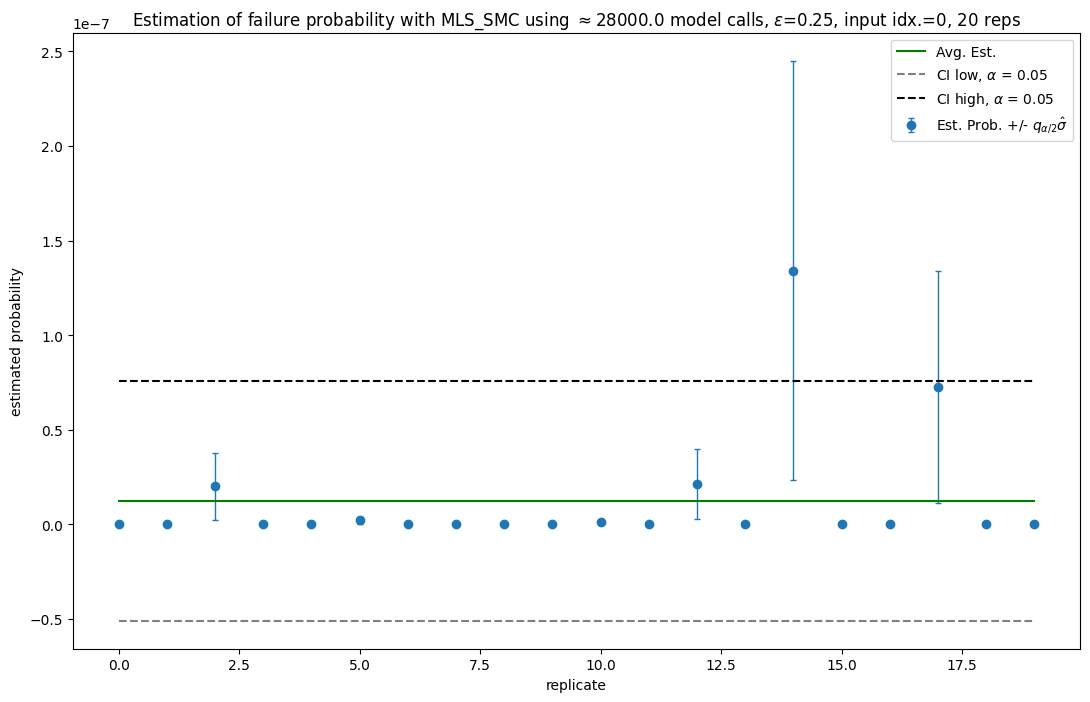

mean est:1.2593444048453368e-08, std est:3.236989722945899e-08
mean calls:28000.0
std. re.:204104362.14619687
std. rel. adj.:5714922140093.513
p_fail_mls: 1.2593444048453368e-08


In [21]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='amls_batch',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=20, update_aggr_res=False, 
                         N_range=[128, 
                                  ],T_range=[10],ratio_range=[0.5,],repeat_exp=False,
                        verbose=1,np_seed=0, torch_seed=0,p_ref = None)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

In [128]:
zero_latent = torch.zeros((1,X[0].numel())).to(device)
x = is_pyt.mpp_search(grad_f = exp_config.gradG, zero_latent=zero_latent,
                       max_iter=1000,  print_every=10,debug=True)

grad_norm_diff: tensor([4.0733], device='cuda:0')
beta: tensor([0.6802], device='cuda:0')
grad_norm_diff: tensor([7.5394], device='cuda:0')
beta: tensor([0.5739], device='cuda:0')
grad_norm_diff: tensor([8.0806], device='cuda:0')
beta: tensor([0.5596], device='cuda:0')
grad_norm_diff: tensor([7.4415], device='cuda:0')
beta: tensor([0.5679], device='cuda:0')
grad_norm_diff: tensor([8.3972], device='cuda:0')
beta: tensor([0.5684], device='cuda:0')
grad_norm_diff: tensor([7.9206], device='cuda:0')
beta: tensor([0.5651], device='cuda:0')
grad_norm_diff: tensor([7.8546], device='cuda:0')
beta: tensor([0.5590], device='cuda:0')
grad_norm_diff: tensor([7.9639], device='cuda:0')
beta: tensor([0.5680], device='cuda:0')
grad_norm_diff: tensor([7.9363], device='cuda:0')
beta: tensor([0.5714], device='cuda:0')
grad_norm_diff: tensor([8.3866], device='cuda:0')
beta: tensor([0.5674], device='cuda:0')
grad_norm_diff: tensor([7.9684], device='cuda:0')
beta: tensor([0.5695], device='cuda:0')
grad_norm_

In [143]:
exp_config= ExpModelConfig(X=X,y=y,model=model,dataset = 'imagenet', model_name = 'resnet18',data_dir = '../data/ImageNet', model_dir = '../models/ImageNet', device = device,
             torch_seed=42,np_seed=0,random_seed=0,real_uniform=True )

Using real uniform distribution (no atoms)


In [144]:
exp_config.update()

In [131]:
X.requires_grad = True

In [132]:
str(exp_config.normal_cdf_layer)

'NormalToUnifLayer()'

In [133]:
x_0 = x_0.detach()

In [134]:
x_carlini = is_pyt.gaussian_space_attack(x_clean= x_0.unsqueeze(0), y_clean=exp_config.y[0], model=exp_config.model,
                                    epsilon=0.25, n_iter=200, step_size=0.02, device=exp_config.device, real_uniform=False,
                                 normal_cdf_layer= None,dim = x_0.numel(),random_init=False,verbose=1)

                                 
                                 

In [135]:
x_carlini

tensor([[[[ 0.0134,  0.0137, -0.0145,  ..., -0.0135, -0.0136, -0.0332],
          [ 0.0135, -0.0135, -0.0134,  ..., -0.0135,  0.0139,  0.0136],
          [ 0.0141, -0.0140,  0.0135,  ..., -0.0134, -0.0142,  0.0136],
          ...,
          [ 0.0135, -0.0135,  0.0135,  ..., -0.0136,  0.0136, -0.0137],
          [ 0.0154, -0.0135,  0.0134,  ..., -0.0138,  0.0360,  0.0145],
          [-0.0135, -0.0134, -0.0136,  ..., -0.0138, -0.0136, -0.0185]],

         [[ 0.0134,  0.0157, -0.0164,  ..., -0.0135, -0.0135, -0.0139],
          [ 0.0134, -0.0135, -0.0134,  ..., -0.0135,  0.0139,  0.0136],
          [ 0.0166, -0.0134, -0.0134,  ..., -0.0134, -0.0143,  0.0137],
          ...,
          [ 0.0135, -0.0135,  0.0136,  ...,  0.0137,  0.0138, -0.0136],
          [ 0.0136,  0.0141,  0.0134,  ...,  0.0145, -0.0136, -0.0142],
          [-0.0134, -0.0134,  0.0136,  ..., -0.0142, -0.0140,  0.0140]],

         [[ 0.0134,  0.0135,  0.0135,  ..., -0.0135, -0.0135, -0.0141],
          [ 0.0135,  0.0139, -

In [120]:
exp_config.G(x_carlini)

tensor([-2.5659], device='cuda:0')

In [167]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=X,y=y,dataset_name=dataset,search_method='carlini',
                        epsilon_range=epsilon_range, n_rep=20, update_aggr_res=False, save_weights=False,
                         N_range=[4000,],batch_size_range=[250],repeat_exp=False,alpha_CI=0.01,x_clean=x_0,
                         y_clean=exp_config.y[0],
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

with parameters in {'N_range': [4000], 'batch_size_range': [250]}
Starting IS simulation 1/1, with model: model, img_idx:0,eps:0.25, N: 4000: batch_size: 250


  0%|          | 0/20 [00:00<?, ?it/s]

AssertionError: x_clean and y_clean must be provided for Carlini-Wagner attack

with parameters in {'N_range': [80000], 'batch_size_range': [8000]}
Starting IS simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:20<00:00, 14.88it/s]


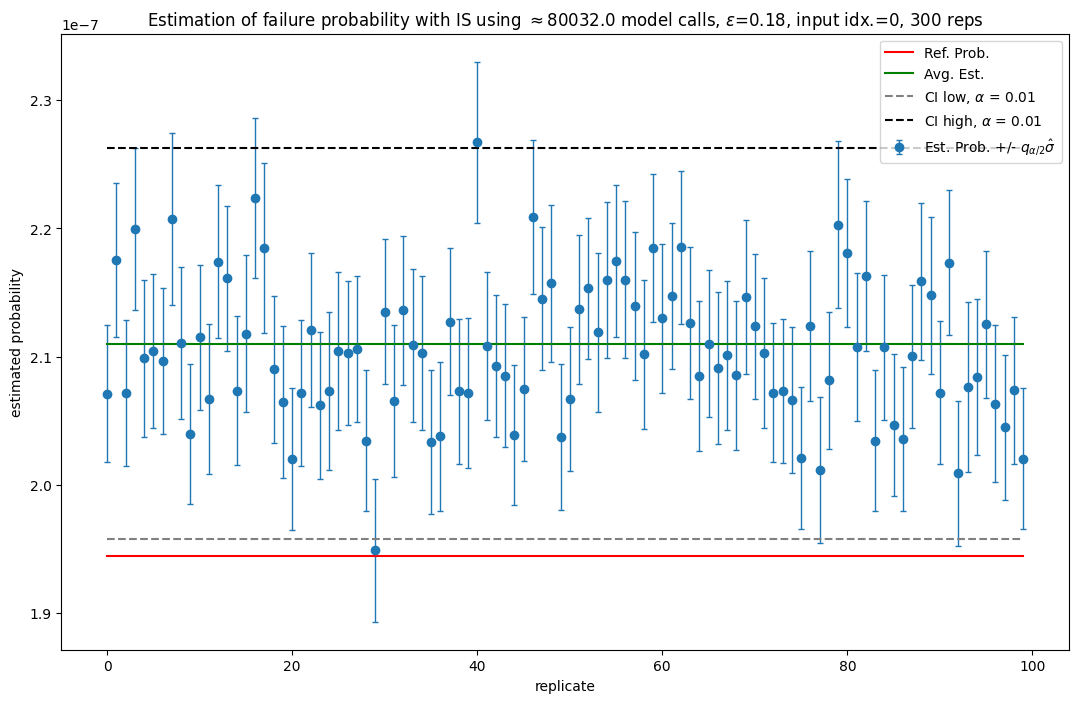

mean est:2.1102624714330886e-07, std est:5.904406297219111e-09
mean calls:80032.0
std. re.:132587.7142317333
std. rel. adj.:10611259945.39408
mean rel. error:0.08518485724925995
std rel. error:0.030362918972969055
stat performance (per 1k calls):2.430005131244659
p_fail_mls: 2.1102624714330886e-07


In [69]:
p_fail_mls,dict_out=run_exp.run_est(model=model,method='is',X=X,y=y,dataset_name=dataset,
                        epsilon_range=epsilon_range, n_rep=300, update_aggr_res=False, 
                         N_range=[80000,],batch_size_range=[8000],repeat_exp=False,alpha_CI=0.01,
                        verbose=0,np_seed=0, torch_seed=0,p_ref = p_ref,sigma_bias=1.)
exp_config,method_config_mls, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mls = dict_out['results_df']
print(f"p_fail_mls: {p_fail_mls}")

In [ ]:
p_fail_mala, dict_out=run_exp.run_stat_rel_exp(model=model,method='mala',X=X,y=y,dataset_name='mnist',
                        n_rep=1, verbose=0, track_accept=False,ess_alpha_range=[0.7,0.8],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[3000],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

[[3000], [20], [0.7, 0.8], [0.2], [1]]
{'N_range': [3000], 'T_range': [20], 'ess_alpha_range': [0.7, 0.8], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.7: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.16s/it]


mean est:7.125619845282927e-07, std est:0.0
mean calls:1806200.0
std. re.:0.0
std. rel. adj.:0.0
Starting MALA_SMC simulation 2/2, with model: mnist_model, img_idx:0,eps:0.18,N: 3000: T: 20: ess_alpha: 0.8: alpha: 0.2: L: 1


100%|██████████| 1/1 [00:03<00:00,  3.41s/it]


mean est:1.429374947292672e-06, std est:0.0
mean calls:1792200.0
std. re.:0.0
std. rel. adj.:0.0
p_fail_mala=1.0709684659104823e-06


with parameters in {'N_range': [500], 'T_range': [20], 'ess_alpha_range': [0.875], 'alpha_range': [0.2], 'L_range': [1]}
Starting MALA_SMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


100%|██████████| 100/100 [00:55<00:00,  1.79it/s]


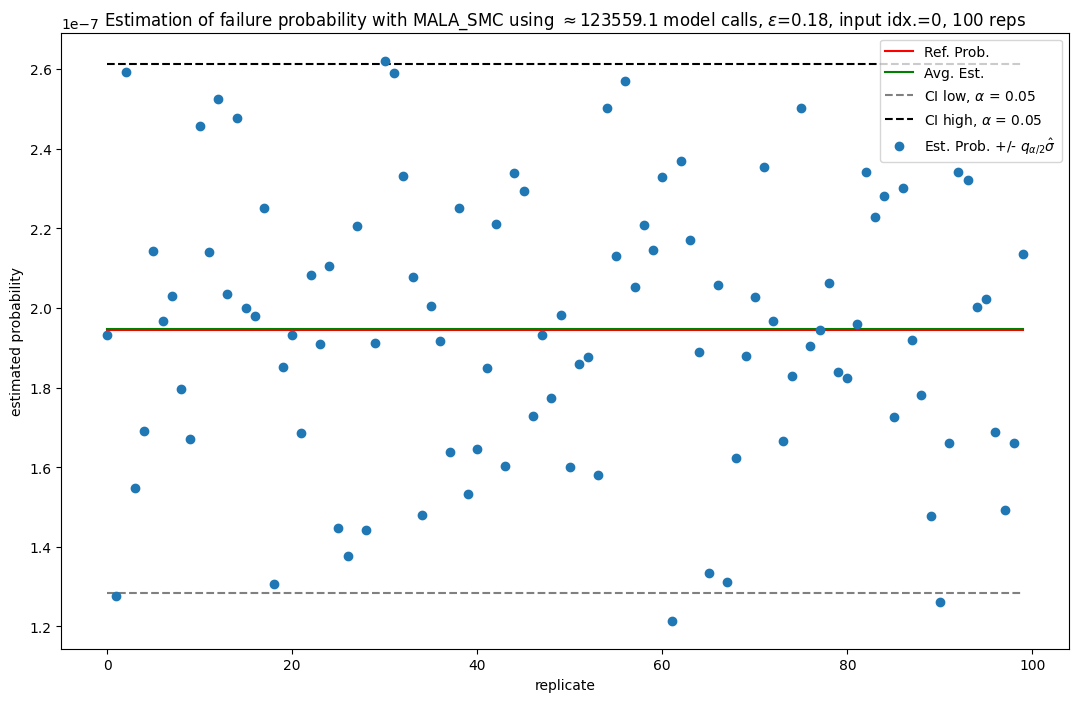

mean est:1.947763398391089e-07, std est:3.3910787382815905e-08
mean calls:123559.1
std. re.:893851.7050677764
std. rel. adj.:110443512211.6399
mean rel. error:0.14067106655076209
std rel. error:0.10307205941389559
stat performance (per 1k calls):12.735490896327468
p_fail_mala=1.947763398391089e-07


In [83]:
p_fail_mala, dict_out=run_exp.run_est(model=model,method='mala2',X=X,y=y,dataset_name='mnist',
                        n_rep=100, verbose=0, track_accept=False,ess_alpha_range=[0.875],
                        alpha=0.2, L_range=[1], adapt_func='simp_ess',p_ref=p_ref,
                         N_range=[500],T_range=[20],epsilon_range=epsilon_range,repeat_exp=True,
 )
exp_config,method_config_mala, agg_res_df = dict_out['exp_config'],dict_out['method_config'],dict_out['agg_res_df']
results_df_mala = dict_out['results_df']
print(f"p_fail_mala={p_fail_mala}")

In [ ]:
exp_config.model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [14]:
model(X)

tensor([[  0.4927,  -4.5988,   2.9991,   5.6759,  -6.5458,   0.6176, -10.5810,
          11.0179,   0.7859,   1.3639]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [50]:
1125858/5e7

0.02251716

In [51]:
p_fail_form,dict_out_form = run_exp.run_stat_rel_exp(model=model,method='form',X=X,y=y,dataset_name='mnist',
                    search_method='carlini',epsilon_range = epsilon_range,
                    steps_range=[1000,],num_iter_range=[10],stepsize_range=[1e-2],
                    repeat_exp=True, random_init=False, 
                    sigma_init=0.000001,
                        
                        
                        n_rep=1, verbose=0,p_ref=p_ref)

[[1000], [10], [0.01]]
{'steps_range': [1000], 'num_iter_range': [10], 'stepsize_range': [0.01]}
Starting FORM simulation 1/1, with model: mnist_model, img_idx:0,eps:0.2,steps: 1000: num_iter: 10: stepsize: 0.01


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.32s/it]


mean est:2.9287436643461935e-10, std est:0.0
mean calls:10000.0
std. re.:0.0
std. rel. adj.:0.0
mean rel. error:0.9999991309993812
std rel. error:0.0
stat performance (per 1k calls):0.0


In [78]:
p_fail_mc, dict_out_mc = run_exp.run_est(model=model, method = 'CrudeMC',
            X=X, y=y, dataset_name='mnist',epsilon_range=epsilon_range,
            repeat_exp=True,n_rep=5, 
            N_range=[int(1e8)],batch_size_range=[int(4e5)],track_advs=False) 

with parameters in {'N_range': [100000000], 'batch_size_range': [400000]}
Starting CrudeMC simulation 1/1, with model: mnist_model, img_idx:0,eps:0.18,


 20%|██        | 1/5 [00:34<02:16, 34.19s/it]


KeyboardInterrupt: 

In [53]:
exp_config.model

dnn2(
  (linear1): Linear(in_features=784, out_features=200, bias=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
  (flat_op): Flatten()
)

## 4. Analysis of Experiments

In [65]:
eps=0.18

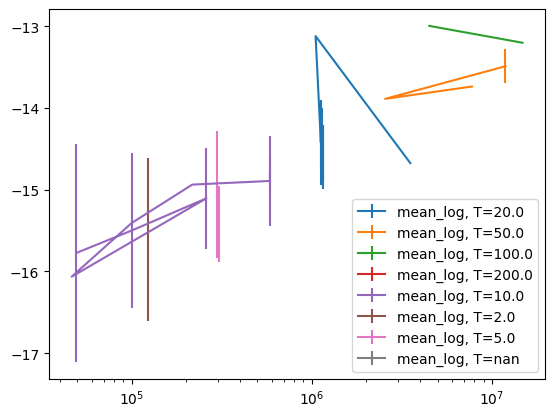

In [68]:
fig=plt.figure()
ax=plt.axes()
ax.set_xscale('log')
mls_webb_df=  utils.get_sel_df(df=agg_res_df,triplets=[('method_name','MALA_SMC','='),])
for T in agg_res_df['T'].unique():
    df = utils.get_sel_df(mls_webb_df,triplets=[('T',T,'='),('epsilon',eps,'=')])
    ax.errorbar(x=df['mean_calls'],y=df['mean_log_est'], yerr=df['std_log_est'],label=f'mean_log, T={T}',)
    ax.legend()

